In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\minorProject\WDSS\jupyter_notebooks
d:\minorProject\WDSS


# Imports

In [2]:
from config import device, Settings
from utils.image_utils import ImageUtils
import torch
import cv2
import numpy as np

## Setting up Dataset

In [3]:
from network.dataset import *

dataset_path = Settings.dataset_path

train_dataset = WDSSDatasetCompressed(os.path.join(dataset_path, 'train'), 119 )

# Load the buffers

In [4]:
image_no = 100

# rendered_image = ImageUtils.load_exr_image_opencv(get_full_path(rendered_img_path, image_no))
# rendered_image_t = ImageUtils.opencv_image_to_tensor(rendered_image)
# base_color = ImageUtils.load_exr_image_opencv(get_full_path(base_color_path, image_no))
# base_color_t = ImageUtils.opencv_image_to_tensor(base_color)
# motion_vector = ImageUtils.load_exr_image_opencv(get_full_path(motion_vector_path, image_no))
# motion_vector_t = ImageUtils.opencv_image_to_tensor(motion_vector)
# normal = ImageUtils.load_exr_image_opencv(get_full_path(world_normal_path, image_no))
# world_normal_t = ImageUtils.opencv_image_to_tensor(world_normal)
# depth = ImageUtils.load_exr_image_opencv(get_full_path(depth_path, image_no))
# depth_t = ImageUtils.opencv_image_to_tensor(depth)

# ImageUtils.display_images([rendered_image, base_color, motion_vector, world_normal, depth], 
#                           ['rendered_image', 'base_color', 'motion_vector', 'world_normal', 'depth'])

raw_frame = train_dataset._get_raw_frames(image_no)
lr_image = raw_frame[RawFrameGroup.LR].unsqueeze(0)
hr_image = raw_frame[RawFrameGroup.HR].unsqueeze(0)
temporal = raw_frame[RawFrameGroup.TEMPORAL].unsqueeze(0)

lr_base_color = raw_frame[RawFrameGroup.LR_GB][GB_Type.BASE_COLOR].unsqueeze(0)
lr_normal = raw_frame[RawFrameGroup.LR_GB][GB_Type.NORMAL].unsqueeze(0)
lr_depth = raw_frame[RawFrameGroup.LR_GB][GB_Type.DEPTH].unsqueeze(0)


hr_base_color = raw_frame[RawFrameGroup.HR_GB][GB_Type.BASE_COLOR].unsqueeze(0)
hr_normal = raw_frame[RawFrameGroup.HR_GB][GB_Type.NORMAL].unsqueeze(0)
hr_depth = raw_frame[RawFrameGroup.HR_GB][GB_Type.DEPTH].unsqueeze(0)

u_lr_image = ImageUtils.upsample(lr_image, 2)
u_lr_base_color = ImageUtils.upsample(lr_base_color, 2)
u_lr_normal = ImageUtils.upsample(lr_normal, 2)
u_lr_depth = ImageUtils.upsample(lr_depth, 2)



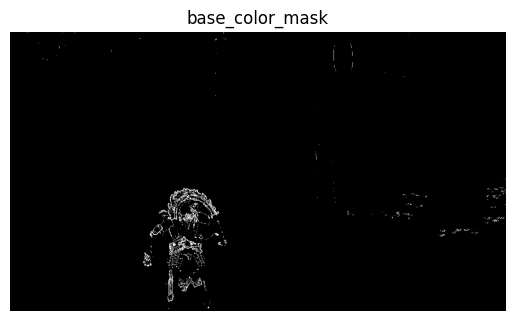

Base color mask: torch.Size([1, 1, 720, 1280])


In [5]:
def base_color_mask(hr_base_color, u_lr_base_color , threshold = 0.1):
    # Base color mask
    base_color_diff = torch.abs(hr_base_color - u_lr_base_color)
    base_color_diff = base_color_diff - threshold
    # Heaviside step function
    base_color_mask = torch.heaviside(base_color_diff, values=torch.tensor(0.0))
    # Convert the 3 channel mask to 1 channel
    base_color_mask = base_color_mask.sum(dim=1, keepdim=True)
    # Clamp the mask to 1
    base_color_mask = torch.clamp(base_color_mask, max=1)

    return base_color_mask

base_color_mask = base_color_mask(hr_base_color, u_lr_base_color)
ImageUtils.display_image(base_color_mask, 'base_color_mask')
print(f'Base color mask: {base_color_mask.shape}')

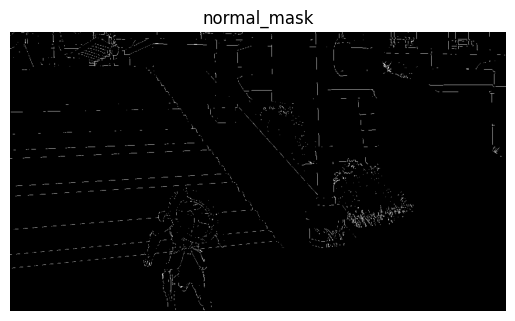

Normal mask: torch.Size([1, 1, 720, 1280])


In [6]:
# Normal mask
def normal_mask( hr_normal, u_lr_normal , threshold = 0.4):
    # Sum the product of the two tensors
    normal_dotted = torch.sum(hr_normal * u_lr_normal, dim=1, keepdim=True)

    # Subtraction
    normal_diff = 0.4 - normal_dotted
    # Heaviside step function
    normal_mask = torch.heaviside(normal_diff, values=torch.tensor(0.0))

    return normal_mask

normal_mask = normal_mask(hr_normal, u_lr_normal)
ImageUtils.display_image(normal_mask, 'normal_mask')
print(f'Normal mask: {normal_mask.shape}')

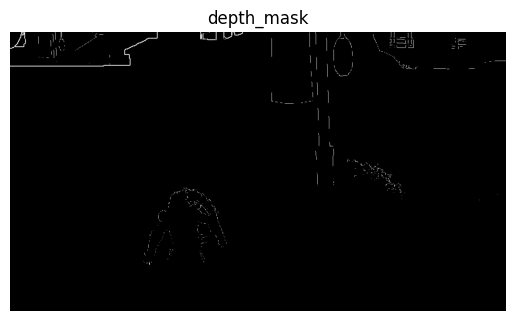

Depth mask: torch.Size([1, 1, 720, 1280])


In [7]:
# Depth mask
def depth_mask(hr_depth, u_lr_depth , threshold=0.04):
    # Subtract the upsampled depth from the high resolution depth keep shape
    depth_diff = hr_depth - u_lr_depth
    depth_diff = torch.abs(depth_diff)
    # Subtract 0.4 from the difference
    depth_diff = depth_diff - threshold

    # Heaviside step function
    depth_mask = torch.heaviside(depth_diff, values=torch.tensor(0.0))

    return depth_mask
    
depth_mask = depth_mask(hr_depth, u_lr_depth)
ImageUtils.display_image(depth_mask, 'depth_mask')
print(f'Depth mask: {depth_mask.shape}')

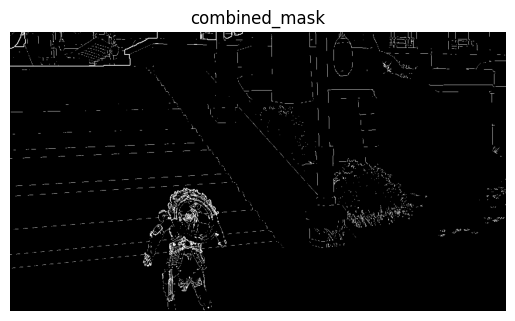

In [8]:
# Combine the masks
combined_mask = base_color_mask + normal_mask + depth_mask
# Clamp the combined mask to 1
combined_mask = torch.clamp(combined_mask, max=1)

# Display the combined mask
ImageUtils.display_image(combined_mask, 'combined_mask')


In [33]:
lr_motion_vector = raw_frame[RawFrameGroup.LR_GB][GB_Type.MOTION_VECTOR].unsqueeze(0)

u_lr_motion_vector = ImageUtils.upsample(lr_motion_vector, 2)

hr_motion_vector = raw_frame[RawFrameGroup.HR_GB][GB_Type.MOTION_VECTOR].unsqueeze(0)